In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import joblib
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic_2d
from tqdm.auto import tqdm

In [3]:
config = toml.load("../preprocessing/config.toml")
data_dir = config["dirs"]["data"]
fig_dir = os.path.expanduser("~/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-04 (QD paper round 2)/")


In [4]:
dist_df = pd.read_parquet(os.path.join(data_dir, "dataframes/accuracy_v_distance_from_camera.parquet"))

In [5]:
filtered_dataset_fname = "/storage/coda1/p-jmarkowitz30/0/shared/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels_qd/kpoint_training_dataset_qd_alignment_round2_manual_labeling_nofluo_version-v1.parquet"

In [6]:
filtered_qd_df = pd.read_parquet(filtered_dataset_fname) 

In [8]:
use_cols = ["centroid_x_world","centroid_y_world","centroid_z_world"]

vel_df = dist_df.drop_duplicates(["session","frame_index"])
diff_df = vel_df.groupby("session")[use_cols].transform(lambda x: x.rolling(6,1,True).mean().diff())

In [9]:
diff_df["velocity"] = np.linalg.norm(diff_df.iloc[:,:2],axis=1)

In [10]:
use_velocity = diff_df["velocity"].to_numpy()

In [11]:
eps = 1e-8

In [12]:
from scipy.ndimage import label

In [13]:
# reasonable thresholds:
# 1. 50 mm/s conservative movement threshold
# 2. 100 mm/s faster movement
# 3. movement for at least 200 ms (~ 6 frames)
speed_thresholds = np.arange(25, 200, 10)
period = .035
min_movement_duration = .1
min_movement_samples = np.ceil(min_movement_duration / period)

In [14]:
filtered_qd_df["session"] = filtered_qd_df["kpoint_avi_fname"].str.extract("(session_[0-9|\-]+) ")

In [15]:
filtered_qd_df["match_col"]= list(zip(filtered_qd_df["session"], filtered_qd_df["frame_index"]))
dist_df["match_col"]= list(zip(dist_df["session"], dist_df["frame_index"]))

In [16]:
filtered_pairs = filtered_qd_df["match_col"].drop_duplicates()

In [17]:
all_session_idx_pairs = dist_df["match_col"].drop_duplicates()
filtered_session_idx_pairs = all_session_idx_pairs[all_session_idx_pairs.isin(filtered_pairs)]

In [18]:
lst = []

for _threshold in speed_thresholds:
    is_moving = (use_velocity / period) > _threshold
    labeled, _ = label(is_moving)
    counts = np.bincount(labeled[labeled > 0])
    valid_labels = np.flatnonzero(counts >= min_movement_samples)
    
    # anything with this session and frame index is now considered moving
    session_idx_pairs = dist_df.loc[diff_df.iloc[valid_labels].index]["match_col"]
    
    # what's the proportion we find in the subset of pairs that were in the filtered data?
    matches = filtered_session_idx_pairs.isin(session_idx_pairs).mean()
    # matches = session_index_pairs.isin(filtered_session_idx_pairs).sum()

    # now normalize by the total number of session/index pairs in the filtered data
    lst.append(matches * 1e2)

In [19]:
from qd_analysis.fig import setup_plotting_env

In [20]:
setup_plotting_env()

In [21]:
pal = sns.color_palette("Reds")

In [22]:
shade_regions = {
    (20,50): pal[0],
    (50,75): pal[1],
    (75,100): pal[2],
    (100,200): pal[3]
}

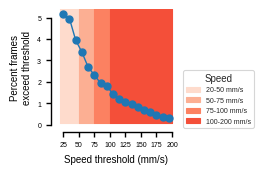

In [25]:
fig, ax = plt.subplots(1, figsize=(1.5,1.5))
ax.plot(speed_thresholds, lst, ms=5, marker="o")
ax.set_ylabel("Percent frames\nexceed threshold")
ax.set_xlabel("Speed threshold (mm/s)")
ylims = ax.get_ylim()
xlims = ax.get_xlim()
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
for k, v in shade_regions.items():
    ax.fill_between(k, y1=ylims[0], y2=ylims[1], color=v, label=f"{k[0]}-{k[1]} mm/s")
ax.set_xticks(np.arange(25,205,25))
ax.set_yticks(np.arange(0,5.5,1.))
ax.legend(bbox_to_anchor=(1.05,.5), title="Speed", title_fontsize=7)
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(fig_dir, "mouse_speed_autolabeled_dataset_proportion.pdf"), bbox_inches="tight", dpi=600)